# Initialisation of Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import dump

# Adjusted feature names (43 columns + label)
nsl_kdd_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'additional_feature', 'Label_num'
]

# Load NSL-KDD dataset with column names (now 43 columns + label)
df_nsl_train = pd.read_csv("e:/Vishnupriya/Dataset/NSL-KDD/KDDTrain+.txt", names=nsl_kdd_columns)
df_nsl_test = pd.read_csv("e:/Vishnupriya/Dataset/NSL-KDD/KDDTest+.txt", names=nsl_kdd_columns)


# Correlation Matrix

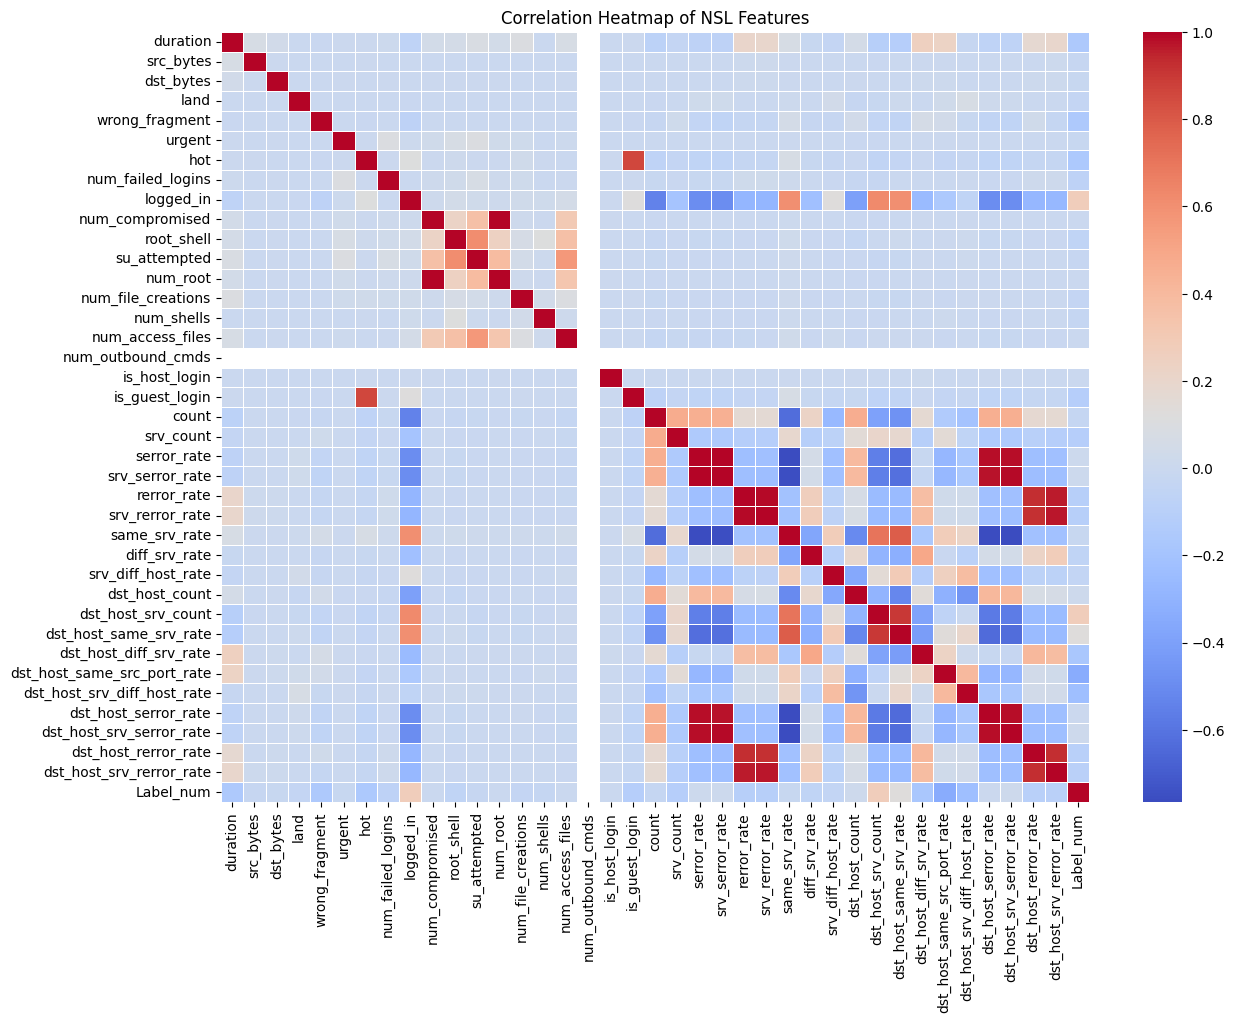

In [3]:
# Correlation matrix for feature selection and visualization
df_nsl_numeric = df_nsl_train.select_dtypes(include=[float, int])  # Ensure only numeric columns
correlation_matrix = df_nsl_numeric.corr()

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of NSL Features')
plt.show()

# Data Preprocessing

In [7]:
# Binary encoding for 'Label' (1 = attack, 0 = normal)
df_nsl_train['Label'] = df_nsl_train['additional_feature'].apply(lambda x: 1 if x != 'normal' else 0)
df_nsl_test['Label'] = df_nsl_test['additional_feature'].apply(lambda x: 1 if x != 'normal' else 0)

# Separate features and labels
X_train_nsl = df_nsl_train.drop('Label', axis=1)
y_train_nsl = df_nsl_train['Label']
X_test_nsl = df_nsl_test.drop('Label', axis=1)
y_test_nsl = df_nsl_test['Label']

# Identify categorical and numeric columns
categorical_cols_nsl = ['protocol_type', 'service', 'flag']
numeric_cols_nsl = X_train_nsl.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ensure OneHotEncoder outputs a dense format
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # Changed sparse to sparse_output
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_nsl),
        ('cat', categorical_transformer, categorical_cols_nsl)
    ])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_nsl, X_test_nsl, y_train_nsl, y_test_nsl = train_test_split(X_train_nsl, y_train_nsl, test_size=0.2, random_state=42)

# After fitting your preprocessing
preprocessor.fit(X_train_nsl)  # Assuming X_train_nsl is your training dataset
dump(preprocessor, 'preprocessor_nsl.joblib')  # Save the fitted preprocessor


['preprocessor_nsl.joblib']

# Evaluation Methods

In [8]:
# Train and evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation metrics for {model_name}:")
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}\n")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f"Confusion Matrix for {model_name} on NSL")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Random Forest Classifier

Evaluation metrics for Random Forest:
Accuracy: 0.9994
Precision: 0.9997
Recall: 0.9992
F1-Score: 0.9994
ROC AUC Score: 0.9994



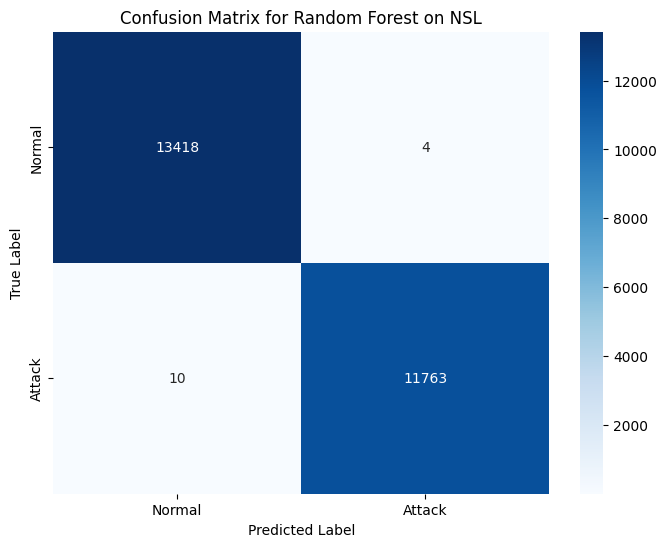

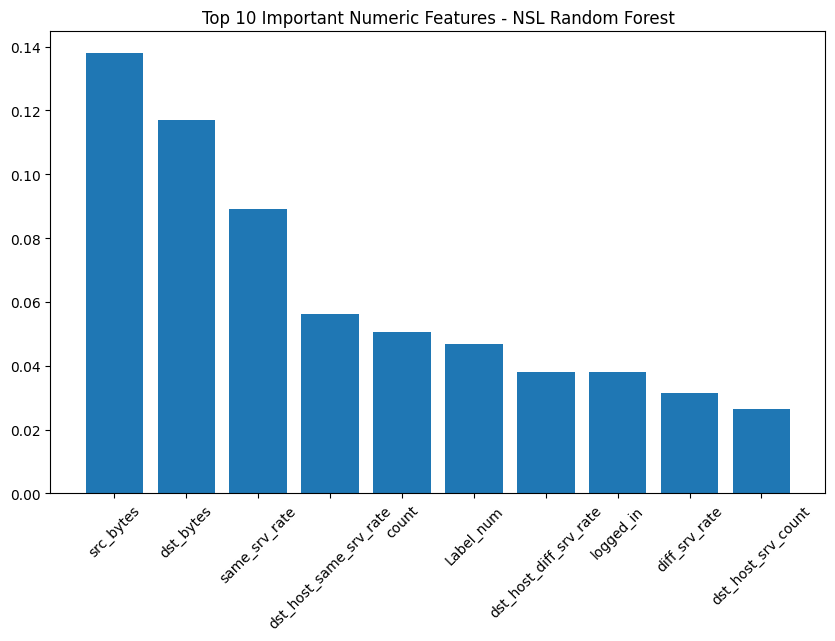

In [9]:
# Random Forest Classifier
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train_nsl, y_train_nsl)
y_pred_rf = rf_model.predict(X_test_nsl)

# Save Random Forest model
dump(rf_model, 'rf_model_nsl.joblib')
evaluate_model(y_test_nsl, y_pred_rf, "Random Forest")

# Feature importance from the RandomForest model (numeric features only)
rf_feature = rf_model.named_steps['classifier']
numeric_feature_importances = rf_feature.feature_importances_[:len(numeric_cols_nsl)]
indices = numeric_feature_importances.argsort()[::-1][:10]  # Top 10 important features

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.title("Top 10 Important Numeric Features - NSL Random Forest")
plt.bar(range(len(indices)), numeric_feature_importances[indices], align="center")
plt.xticks(range(len(indices)), [numeric_cols_nsl[i] for i in indices], rotation=45)
plt.show()


# XGBoost Classifier

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation metrics for XGBoost:
Accuracy: 0.9995
Precision: 0.9997
Recall: 0.9992
F1-Score: 0.9995
ROC AUC Score: 0.9995



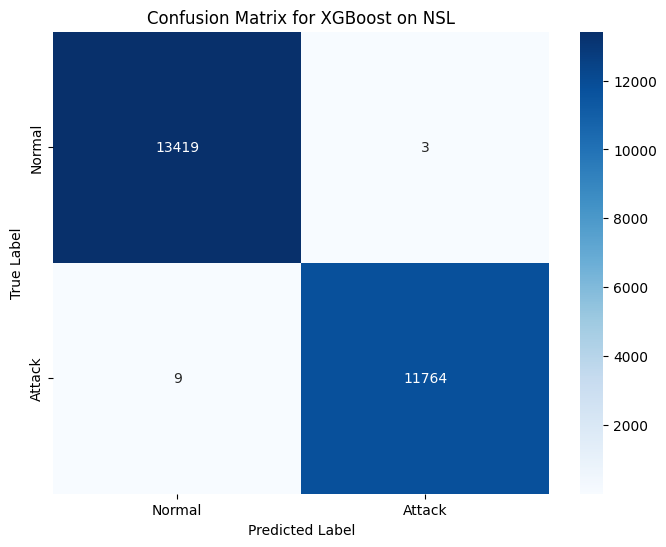

In [10]:
# XGBoost Classifier
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_model.fit(X_train_nsl, y_train_nsl)
y_pred_xgb = xgb_model.predict(X_test_nsl)


# Save XGBoost model
dump(xgb_model, 'xgb_model_nsl.joblib')
evaluate_model(y_test_nsl, y_pred_xgb, "XGBoost")

# Isolation Forest

Evaluation metrics for Isolation Forest:
Accuracy: 0.5852
Precision: 0.7629
Recall: 0.1629
F1-Score: 0.2685
ROC AUC Score: 0.5593



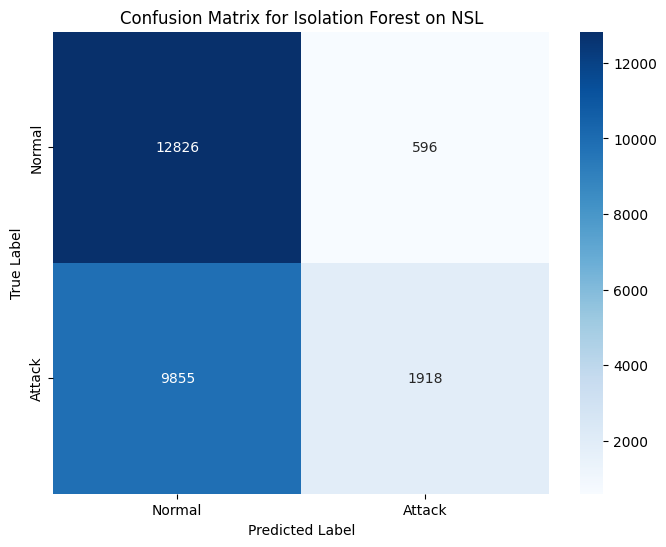

In [12]:
# Isolation Forest for anomaly detection
iso_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', IsolationForest(contamination=0.1, random_state=42))
])
iso_forest.fit(X_train_nsl)
y_pred_iso = iso_forest.predict(X_test_nsl)
y_pred_iso = [0 if pred == 1 else 1 for pred in y_pred_iso]  # Convert to binary labels

# Save Isolation Forest model
dump(iso_forest, 'iso_forest_model_nsl.joblib')
evaluate_model(y_test_nsl, y_pred_iso, "Isolation Forest")

# Autoencoder

c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2908 - val_loss: 0.2158
Epoch 2/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2297 - val_loss: 0.2153
Epoch 3/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2711 - val_loss: 0.2139
Epoch 4/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2319 - val_loss: 0.2135
Epoch 5/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2441 - val_loss: 0.2135
Epoch 6/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2414 - val_loss: 0.2133
Epoch 7/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2766 - val_loss: 0.2125
Epoch 8/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2457 - val_loss: 0.2044
Epoch 9/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2348 - val_loss: 0.2041
Epoch 10/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2447 - val_loss: 0.2011
Epoch 11/50
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2425 - val_loss: 0.2011
Epoch 12/50
3150/3150 ━━━━━━━

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step
Evaluation metrics for Autoencoder:
Accuracy: 0.5630
Precision: 0.8024
Recall: 0.0859
F1-Score: 0.1551
ROC AUC Score: 0.5337



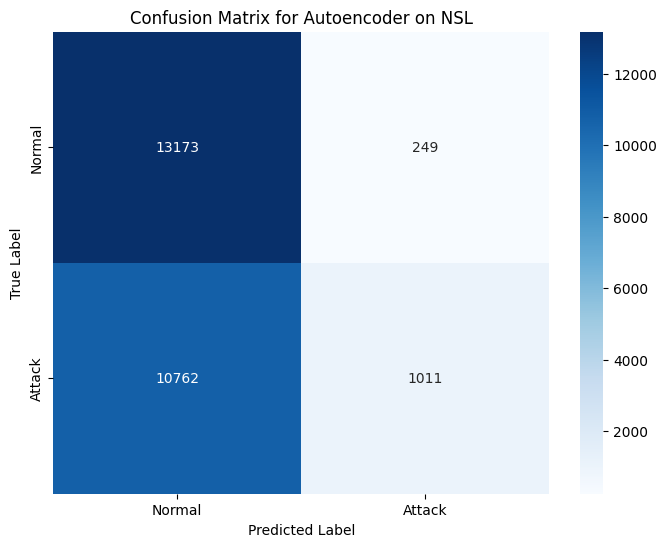

In [24]:
# Autoencoder for anomaly detection
def create_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))
    return model

# Preprocess the data before training the Autoencoder
X_train_autoencoder = preprocessor.fit_transform(X_train_nsl)
X_test_autoencoder = preprocessor.transform(X_test_nsl)

autoencoder = create_autoencoder(X_train_autoencoder.shape[1])
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_autoencoder, X_train_autoencoder, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test_autoencoder, X_test_autoencoder))

# Save Autoencoder model
autoencoder.save('autoencoder_model_nsl.h5')

# Anomaly detection using Autoencoder
reconstructed = autoencoder.predict(X_test_autoencoder)
loss = np.mean(np.abs(reconstructed - X_test_autoencoder), axis=1)
threshold = np.percentile(loss, 95)  # Adjust based on desired sensitivity
y_pred_autoencoder = [1 if i > threshold else 0 for i in loss]

# Evaluate Autoencoder
evaluate_model(y_test_nsl, y_pred_autoencoder, "Autoencoder")